- Aim of this notebook
    - Train a function that can convert graph into graph embeddings
    - Given a graph, learn embeddings of the nodes using only the graph structure and the node features, without using any known node class labels
    - How this graph embeddings can be used for recommendation?
        - Use cosine similarity between user node and the listing node as a feature to predict the rating the user will put on all the listings, then rank by rating accordingly
        - Use K nearest neighbors (Research pinsage)
        - approximate nearest neighbor search
            - [FAISS](https://github.com/facebookresearch/faiss/wiki) from Facebook
            - [Annoy](https://github.com/spotify/annoy) from Spotify
            - [Scann](https://github.com/google-research/google-research/tree/master/scann?source=techstories.org) from Google (which is to date the fastest implementation to date)
    - Need to have a baseline model like matrix factorization model/ random generated list
- Possible improvements
    - user embeddings could be the embeddings of their own profile picture
    - PinnerSage
    - Use Uber hingeloss
    - Use rating difference as loss
    - built a listing-to-listing graph, connecting listings if the same user reviews on both

In [1]:
import pandas as pd
from loguru import logger
import torch
import torch.nn.functional as F
from datetime import datetime as dt
import os
from dateutil.relativedelta import relativedelta  # type: ignore
import functools
from sklearn.manifold import TSNE
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from process_data import *
from constants import *
from model import *
from evaluate import *



In [2]:
start_date = dt.strptime("2021-10-24", "%Y-%m-%d").date()
if start_date == dt.strptime(MAX_START_DATE, "%Y-%m-%d").date():
    raise Exception("Stop Simulation")
end_date, nxt_start_date = split_date_by_period_months(start_date, TOTAL_MONTHS_PER_ITERATION)
print(start_date, end_date)
directory = "/Users/yhchan/Downloads/FYP/data/processed"
reviews = pd.read_parquet(f"{directory}/reviews_with_interactions.parquet")
listings = pd.read_parquet(f"{directory}/listings_with_interactions.parquet")

config = {
        "start_date": start_date,
        "end_date": end_date,
        "learning_rate": 0.01,
        "hidden_channels": 64,
        "train_batch_size": 128,
        "test_batch_size": 128,
        "train_num_neighbours": [10, 10],
        "test_num_neighbours": [-1],
        "train_split_period_months": 10,
        "total_months_of_data": TOTAL_MONTHS_PER_ITERATION,
        "rec_K":5
    }

# Split into train, test and test for cold start scenario
(
    train_reviews,
    train_listings,
    train_reviewers,
    test_reviews,
    test_listings,
    test_reviewers,
) = main_train_test(
    reviews,
    listings,
    start_date,
    end_date,
    config["train_split_period_months"],
)

# Build Graph
involved_reviews = pd.concat([train_reviews, test_reviews])
involved_listings, involved_reviewers = build_partitioned_data(involved_reviews, listings)
involved_data = build_heterograph(involved_reviews, involved_listings, involved_reviewers, True)
print("Whole Graph", involved_data)

2021-10-24 2022-10-23


2023-04-30 00:10:22.660 | INFO     | process_data:main_train_test:140 - Split df into train and test portion
/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/process_data.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525682339/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  temp = torch.from_numpy(val).view(-1, 1).to(torch.float32)


Whole Graph HeteroData(
  listing={ x=[18523, 158] },
  user={ x=[394551, 384] },
  (user, rates, listing)={
    edge_index=[2, 408596],
    edge_label=[408596],
    edge_label_index=[2, 408596]
  },
  (listing, rev_rates, user)={ edge_index=[2, 408596] }
)


In [11]:
directory = "/Users/yhchan/Downloads/FYP/data/processed"

involved_reviews = pd.read_parquet('i.parquet')
listings = pd.read_parquet(f"{directory}/listings_with_interactions.parquet")
involved_listings, involved_reviewers = build_partitioned_data(involved_reviews, listings)

_reviews = involved_reviews.copy().sample(1000)
_listings = involved_listings.copy()
distinct_listings_in_reviews = _reviews["listing_id"].unique()
_listings = _listings[_listings["listing_id"].isin(distinct_listings_in_reviews)]
_reviewers = retrieve_unique_reviewers(_reviews)

1000


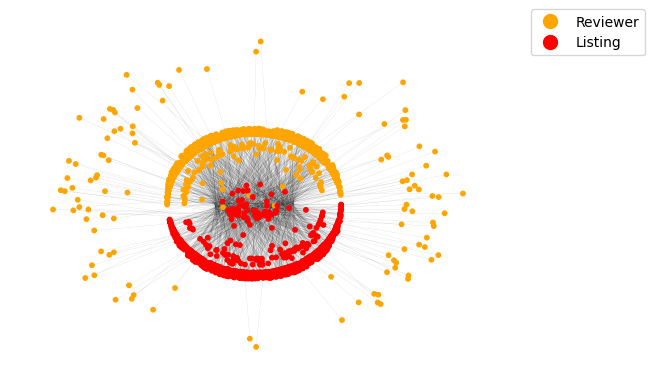

1000
940


In [12]:
# Illustrate the bipartite graph
print(len(_reviews))

user_x, user_mapping = load_node_from_df(
    _reviewers, index_col="reviewer_id"
)
listing_x, listing_mapping = load_node_from_df(
    _listings, index_col="listing_id"
)
src_index_col="reviewer_id"
src_mapping=user_mapping
dst_index_col="listing_id"
dst_mapping=listing_mapping
src_list = [src_mapping[index] for index in _reviews[src_index_col]]
dst_list = [dst_mapping[index] for index in _reviews[dst_index_col]]
edge_weight_list = _reviews['rating'].values.tolist()
reviewer_nodes = [('reviewer', user_label) for user_label in user_mapping.values()]
listing_nodes = [('listing', listing_label) for listing_label in listing_mapping.values()]


# Define the nodes and edges of the graph
nodes = []
edges = []

nodes.extend(reviewer_nodes)
nodes.extend(listing_nodes)
for index in range(len(src_list)):
    src = src_list[index]
    dst = dst_list[index]
    weight = edge_weight_list[index]
    edge = (('reviewer', src), ('listing', dst), {'weight': weight})
    edges.append(edge)


# Create a new graph and add the nodes and edges
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

# Set the node colors based on their type
node_colors = {
    'reviewer': 'orange',
    'listing': 'red'
}
colors = [node_colors[node[0]] for node in graph.nodes()]

# Set the edge labels to their weights
edge_labels = nx.get_edge_attributes(graph, 'weight')

# Draw the graph with edge labels
pos = nx.kamada_kawai_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=10, node_color=colors)
nx.draw_networkx_edges(graph, pos, width=[d['weight']/50 for (u, v, d) in graph.edges(data=True)], alpha=0.3)
# nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.4)

# Add a legend for the node colors
user_patch = plt.plot([], [], marker='o', ms=10, ls='', mec=None, color=node_colors['reviewer'], label='Reviewer')[0]
item_patch = plt.plot([], [], marker='o', ms=10, ls='', mec=None, color=node_colors['listing'], label='Listing')[0]
plt.legend(handles=[user_patch, item_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the graph
plt.axis('off')
plt.show()
print(len(reviewer_nodes))
print(len(listing_nodes))

Start generating embeddings
Finish generating embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18523 samples in 0.009s...
[t-SNE] Computed neighbors for 18523 samples in 0.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18523
[t-SNE] Computed conditional probabilities for sample 2000 / 18523
[t-SNE] Computed conditional probabilities for sample 3000 / 18523
[t-SNE] Computed conditional probabilities for sample 4000 / 18523
[t-SNE] Computed conditional probabilities for sample 5000 / 18523
[t-SNE] Computed conditional probabilities for sample 6000 / 18523
[t-SNE] Computed conditional probabilities for sample 7000 / 18523
[t-SNE] Computed conditional probabilities for sample 8000 / 18523
[t-SNE] Computed conditional probabilities for sample 9000 / 18523
[t-SNE] Computed conditional probabilities for sample 10000 / 18523
[t-SNE] Computed conditional probabilities for sample 11000 / 18523
[t-SNE] Computed conditional probabilities for sample 12000 /

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

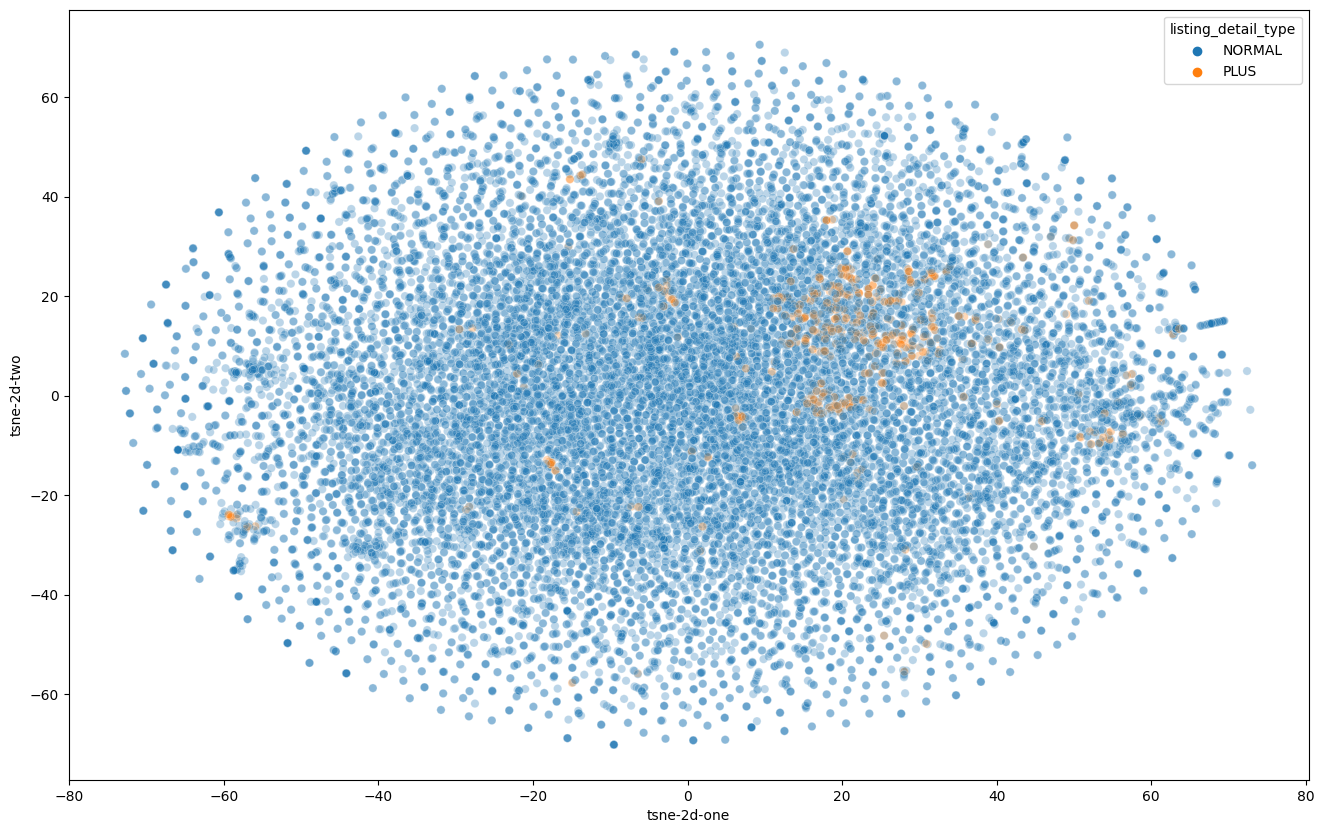

In [3]:
# Visualize the embeddings for nodes that are used in model training and model evaluation only using t-SNE

path_prefix = './best_models'
best_rating_weighted_model_path = f"{path_prefix}/rating_weighted_graphsage_state_dict.pt"
best_rating_weighted_model = load_model(best_rating_weighted_model_path, config["hidden_channels"], involved_data)
@torch.no_grad()
def generate_listing_embeddings_dict(graph_data, listings, model):
    print("Start generating embeddings")

    model.eval()
    embeddings = model.inference(graph_data.x_dict, graph_data.edge_index_dict)
    print("Finish generating embeddings")
    user_embeddings = embeddings["user"]
    listing_embeddings = embeddings["listing"]

    return listing_embeddings

listing_embeddings = generate_listing_embeddings_dict(
    involved_data, involved_listings, best_rating_weighted_model
)
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(listing_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
involved_listings['tsne-2d-one'] = tsne_proj[:,0]
involved_listings['tsne-2d-two'] = tsne_proj[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="listing_detail_type",
    data=involved_listings,
    legend="full",
    alpha=0.3
)